# INFO-4604/5604 HW2: Linear Classification: Final Project
## UFC Fight Prediction Code

### Nikolai Alexander

## Data Collection and Preprocessing

### Data Collection & Cleaning

In [1]:
# Used Libraries
import pandas as pd
import numpy as np
import re
import functools
import requests
from bs4 import BeautifulSoup
import random
import copy
import matplotlib.pyplot as mpl
from sklearn import preprocessing
from dateutil.relativedelta import relativedelta
from datetime import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

# Set seed to initialize random date (For reproducibility)
np.random.seed(seed=3985)

In [2]:
# Import Raw data
fighter_data_raw = pd.read_csv("UFC_Fighters_1993-2016 (raw).csv",header=0)

print(fighter_data_raw.head())
print()
print("fighter_data_raw shape:",fighter_data_raw.shape)

                                 url    fid                name  \
0      /fighter/Conor-McGregor-29688  29688      Conor McGregor   
1           /fighter/Jon-Jones-27944  27944           Jon Jones   
2          /fighter/Holly-Holm-75125  75125          Holly Holm   
3       /fighter/Dominick-Cruz-12107  12107       Dominick Cruz   
4  /fighter/Demetrious-Johnson-45452  45452  Demetrious Johnson   

                      nick  birth_date height  weight       association  \
0                Notorious   7/14/1988     68   145.0       SBG Ireland   
1                    Bones   7/19/1987     76   205.0  Jackson-Wink MMA   
2  The Preacher's Daughter  10/17/1981     68   135.0  Jackson-Wink MMA   
3            The Dominator    9/3/1985     68   134.0      Alliance MMA   
4             Mighty Mouse   8/13/1986     63   125.0    AMC Pankration   

               class                 locality        country  
0      Featherweight                   Dublin        Ireland  
1  Light Heavyweight

In [3]:
# Reduce duplicate columns and add column for annotation
fighter_data_raw.drop_duplicates(subset='name',keep='first',inplace=True)
fighter_data_raw.insert(len(fighter_data_raw.columns),'base_style', None)

# Create new file to annotate
print(fighter_data_raw.shape)
fighter_data_raw.to_csv('UFC_Fighters_1993-2016 (reduced).csv', index=False)

# Delete raw data from memory - Don't need it anymore
del fighter_data_raw

(1526, 12)


In [4]:
# Import annotated file
fighter_data_ann = pd.read_csv("UFC_Fighters_1993-2016 (annotated).csv")

# Change all cases to lower
fighter_data_ann['url'] = fighter_data_ann['url'].str.lower()
fighter_data_ann['name'] = fighter_data_ann['name'].str.lower()
fighter_data_ann['nick'] = fighter_data_ann['nick'].str.lower()
fighter_data_ann['association'] = fighter_data_ann['association'].str.lower()
fighter_data_ann['class'] = fighter_data_ann['class'].str.lower()
fighter_data_ann['locality'] = fighter_data_ann['locality'].str.lower()
fighter_data_ann['country'] = fighter_data_ann['country'].str.lower()
fighter_data_ann['base_style'] = fighter_data_ann['base_style'].str.lower()

# Add new columns for win, loss, and win percentage
fighter_data_ann.insert(len(fighter_data_ann.columns),'num_wins', None)
fighter_data_ann.insert(len(fighter_data_ann.columns),'num_losses', None)
fighter_data_ann.insert(len(fighter_data_ann.columns),'total_fights', None)
fighter_data_ann.insert(len(fighter_data_ann.columns),'win_rate', None)

# Scrape data for win, loss and win percentage
for i, row in fighter_data_ann.iterrows() :
    sd_url = 'http://www.sherdog.com' + row['url']

    html = requests.get(sd_url).text
    soup = BeautifulSoup(html, 'lxml')

    win = soup.find('div', {'class', 'bio_graph'})
    loss = soup.find('div', {'class', 'bio_graph loser'})
    
    num_wins = int(win.find('span', {'class', 'counter'}).text)
    num_losses = int(loss.find('span', {'class', 'counter'}).text)
    total_fights = num_wins + num_losses
    if total_fights != 0:
        win_perc = num_wins / total_fights
    else :
        win_perc = 0
    
    fighter_data_ann.at[i,'num_wins'] = num_wins
    fighter_data_ann.at[i,'num_losses'] = num_losses
    fighter_data_ann.at[i,'total_fights'] = total_fights
    fighter_data_ann.at[i,'win_rate'] = win_perc

    # Clean countries column
    if fighter_data_ann.at[i,'country'] == 'united states' :
        fighter_data_ann.at[i,'country'] = 'usa'
   
    if fighter_data_ann.at[i,'country'] == 'northern ireland' :
        fighter_data_ann.at[i,'country'] = 'ireland'

    if fighter_data_ann.at[i,'country'] == 'holland' :
        fighter_data_ann.at[i,'country'] = 'netherlands'
        
    if fighter_data_ann.at[i,'country'] == 'iran, islamic republic of' :
        fighter_data_ann.at[i,'country'] = 'iran'
        
    if fighter_data_ann.at[i,'country'] == 'finnland' :
        fighter_data_ann.at[i,'country'] = 'finland'

    # If they found unaffiliated to a gym, make that a data point     
    if fighter_data_ann.at[i,'association'] == np.nan :
        fighter_data_ann.at[i,'association'] = 'unaffiliated'
    
# Import new data to csv
fighter_data_ann.to_csv('UFC_Fighters_1993-2016 (complete).csv', index=False)

# Delete dataframe from memory - Function takes too long to run, so we can call
# the new created file when we need it.
del fighter_data_ann

In [5]:
fight_data_raw = pd.read_csv("UFC_Fights_1993-2016 (raw).csv",header=0)

print(fight_data_raw.head())
print()
print("fight_data_raw shape:",fight_data_raw.shape)

                         pageurl  eid  mid             event_name  \
0  /events/UFC-1-The-Beginning-7    7    8  UFC 1 - The Beginning   
1  /events/UFC-1-The-Beginning-7    7    7  UFC 1 - The Beginning   
2  /events/UFC-1-The-Beginning-7    7    6  UFC 1 - The Beginning   
3  /events/UFC-1-The-Beginning-7    7    5  UFC 1 - The Beginning   
4  /events/UFC-1-The-Beginning-7    7    4  UFC 1 - The Beginning   

                        event_org  event_date  \
0  Ultimate Fighting Championship  11/12/1993   
1  Ultimate Fighting Championship  11/12/1993   
2  Ultimate Fighting Championship  11/12/1993   
3  Ultimate Fighting Championship  11/12/1993   
4  Ultimate Fighting Championship  11/12/1993   

                                        event_place  \
0  McNichols Arena, Denver, Colorado, United States   
1  McNichols Arena, Denver, Colorado, United States   
2  McNichols Arena, Denver, Colorado, United States   
3  McNichols Arena, Denver, Colorado, United States   
4  McNichols Ar

In [6]:
print(fight_data_raw['f1result'].value_counts().to_dict())
print(fight_data_raw.f2result.value_counts().to_dict())

{'win': 3510, 'NC': 38, 'draw': 21}
{'loss': 3510, 'NC': 38, 'draw': 21}


In [7]:
# Change all cases to lower
fight_data_raw['pageurl'] = fight_data_raw['pageurl'].str.lower()
fight_data_raw['event_name'] = fight_data_raw['event_name'].str.lower()
fight_data_raw['event_org'] = fight_data_raw['event_org'].str.lower()
fight_data_raw['event_place'] = fight_data_raw['event_place'].str.lower()
fight_data_raw['f1pageurl'] = fight_data_raw['f1pageurl'].str.lower()
fight_data_raw['f2pageurl'] = fight_data_raw['f2pageurl'].str.lower()
fight_data_raw['f1name'] = fight_data_raw['f1name'].str.lower()
fight_data_raw['f2name'] = fight_data_raw['f2name'].str.lower()
fight_data_raw['f1result'] = fight_data_raw['f1result'].str.lower()
fight_data_raw['f2result'] = fight_data_raw['f2result'].str.lower()
fight_data_raw['method'] = fight_data_raw['method'].str.lower()
fight_data_raw['method_d'] = fight_data_raw['method_d'].str.lower()
fight_data_raw['ref'] = fight_data_raw['ref'].str.lower()


# Randomize fighter1 and fighter2 in order to spread the data a little better
for i, row in fight_data_raw.iterrows() :
    # random integer to determine if the fighters should be switched or not
    switch_var = random.randint(0,1)
    
    if switch_var == 1 :
        temp_fpageurl = copy.deepcopy(fight_data_raw.at[i,'f1pageurl'])
        temp_fname = copy.deepcopy(fight_data_raw.at[i,'f1name'])
        temp_fresult = copy.deepcopy(fight_data_raw.at[i,'f1result'])
        temp_fid = copy.deepcopy(fight_data_raw.at[i,'f1fid'])
        
        fight_data_raw.at[i,'f1pageurl'] = copy.deepcopy(fight_data_raw.at[i,'f2pageurl'])
        fight_data_raw.at[i,'f1name'] = copy.deepcopy(fight_data_raw.at[i,'f2name'])
        fight_data_raw.at[i,'f1result'] = copy.deepcopy(fight_data_raw.at[i,'f2result'])
        fight_data_raw.at[i,'f1fid'] = copy.deepcopy(fight_data_raw.at[i,'f2fid'])

        fight_data_raw.at[i,'f2pageurl'] = copy.deepcopy(temp_fpageurl)
        fight_data_raw.at[i,'f2name'] = copy.deepcopy(temp_fname)
        fight_data_raw.at[i,'f2result'] = copy.deepcopy(temp_fresult)
        fight_data_raw.at[i,'f2fid'] = copy.deepcopy(temp_fid)

# Shuffle instances to get rid of time dependency
fight_data_raw = fight_data_raw.sample(frac=1).reset_index(drop=True)
        
print(fight_data_raw['f1result'].value_counts().to_dict())
print(fight_data_raw.f2result.value_counts().to_dict())

fight_data_raw.to_csv('UFC_Fights_1993-2016 (complete).csv', index=False)
del fight_data_raw

{'win': 1763, 'loss': 1747, 'nc': 38, 'draw': 21}
{'loss': 1763, 'win': 1747, 'nc': 38, 'draw': 21}


### Feature Selection & Engineering

In [2]:
fighter_data = pd.read_csv("UFC_Fighters_1993-2016 (complete).csv",header=0)
fight_data = pd.read_csv("UFC_Fights_1993-2016 (complete).csv",header=0)

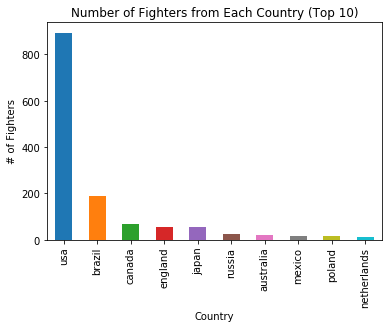

In [40]:
fighter_data['country'].value_counts()[:10].plot(kind='bar')
mpl.xlabel('Country')
mpl.ylabel('# of Fighters')
mpl.title('Number of Fighters from Each Country (Top 10)')

mpl.savefig('country_hist.png')

mpl.show()

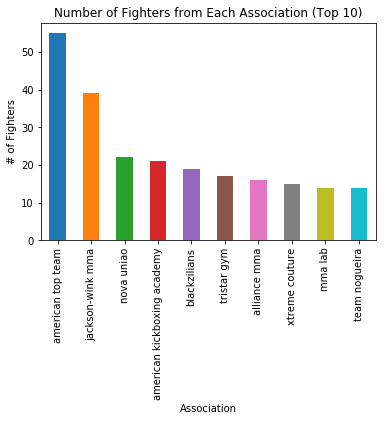

In [41]:
fighter_data['association'].value_counts()[:10].plot(kind='bar')
mpl.xlabel('Association')
mpl.ylabel('# of Fighters')
mpl.title('Number of Fighters from Each Association (Top 10)')

mpl.savefig('gym_hist.png')

mpl.show()

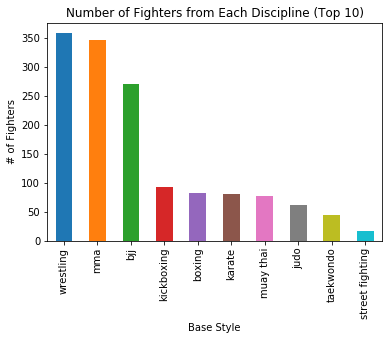

In [44]:
fighter_data['base_style'].value_counts()[:10].plot(kind='bar')
mpl.xlabel('Base Style')
mpl.ylabel('# of Fighters')
mpl.title('Number of Fighters from Each Discipline (Top 10)')

mpl.savefig('style_hist.png')

mpl.show()

In [3]:
# Create Dataframe to caluclated weighted win rate based off number of fighters in each nationality + the win rate of the nation
country_index = fighter_data['country'].value_counts(normalize=True).index.tolist()
country_value = fighter_data['country'].value_counts(normalize=True).values.tolist()
country_df = pd.DataFrame({'country': country_index, 'norm_count': country_value })

country_df.insert(len(country_df.columns),'wins', 0)
country_df.insert(len(country_df.columns),'total', 0)
country_df.insert(len(country_df.columns),'win_rate', 0)
country_df.insert(len(country_df.columns),'weighted_wr', 0)

for i, row in fighter_data.iterrows() :
    for j, row in country_df.iterrows() :
        if fighter_data.at[i,'country'] == country_df.at[j,'country'] :
            country_df.at[j,'wins'] += fighter_data.at[i,'num_wins']
            country_df.at[j,'total'] += fighter_data.at[i,'total_fights']
            break


country_df['win_rate'] = country_df['wins']/country_df['total']
country_df['weighted_wr'] = country_df['norm_count'] + country_df['win_rate']

print(country_df.head())
print(country_df.tail())

   country  norm_count   wins  total  win_rate  weighted_wr
0      usa    0.596398  13520  19947  0.677796     1.274194
1   brazil    0.125417   3235   4477  0.722582     0.847999
2   canada    0.046698   1082   1582  0.683944     0.730642
3  england    0.036691    829   1220  0.679508     0.716199
4    japan    0.036691   1197   1816  0.659141     0.695832
        country  norm_count  wins  total  win_rate  weighted_wr
54      iceland    0.000667    17     20  0.850000     0.850667
55  puerto rico    0.000667     0      1  0.000000     0.000667
56     paraguay    0.000667     8     11  0.727273     0.727940
57       angola    0.000667     7      9  0.777778     0.778445
58         guam    0.000667    10     15  0.666667     0.667334


In [4]:
# Create dataframe in order to calculate weighted win rate based off number of fighters from the gym + the win rate of that gym
gym_index = fighter_data['association'].value_counts(normalize=True).index.tolist()
gym_value = fighter_data['association'].value_counts(normalize=True).values.tolist()
gym_df = pd.DataFrame({'association': gym_index, 'norm_count': gym_value })

gym_df.insert(len(gym_df.columns),'wins', 0)
gym_df.insert(len(gym_df.columns),'total', 0)
gym_df.insert(len(gym_df.columns),'win_rate', 0)
gym_df.insert(len(gym_df.columns),'weighted_wr', 0)

for i, row in fighter_data.iterrows() :
    for j, row in gym_df.iterrows() :
        if fighter_data.at[i,'association'] == gym_df.at[j,'association'] :
            gym_df.at[j,'wins'] += fighter_data.at[i,'num_wins']
            gym_df.at[j,'total'] += fighter_data.at[i,'total_fights']
            break


gym_df['win_rate'] = gym_df['wins']/gym_df['total']
gym_df['weighted_wr'] = gym_df['norm_count'] + gym_df['win_rate']

print(gym_df.head())
print(gym_df.tail())

                   association  norm_count  wins  total  win_rate  weighted_wr
0            american top team    0.041137  1026   1477  0.694651     0.735788
1             jackson-wink mma    0.029170   756   1075  0.703256     0.732426
2                   nova uniao    0.016455   419    545  0.768807     0.785262
3  american kickboxing academy    0.015707   318    454  0.700441     0.716147
4                 blackzilians    0.014211   334    469  0.712154     0.726364
             association  norm_count  wins  total  win_rate  weighted_wr
646  gracie barra sydney    0.000748    10     16  0.625000     0.625748
647    primus fight team    0.000748    26     37  0.702703     0.703451
648                 vmat    0.000748    27     35  0.771429     0.772177
649          spirit dojo    0.000748    40     56  0.714286     0.715034
650     bushido bulgaria    0.000748    12     14  0.857143     0.857891


In [11]:
# Create dataframe in order to calculate weighted win rate based off number of fighters with base_style + the win rate of that base_style
style_index = fighter_data['base_style'].value_counts(normalize=True).index.tolist()
style_value = fighter_data['base_style'].value_counts(normalize=True).values.tolist()
style_df = pd.DataFrame({'base_style': style_index, 'norm_count': style_value })

style_df.insert(len(style_df.columns),'wins', 0)
style_df.insert(len(style_df.columns),'total', 0)
style_df.insert(len(style_df.columns),'win_rate', 0)
style_df.insert(len(style_df.columns),'weighted_wr', 0)

for i, row in fighter_data.iterrows() :
    for j, row in style_df.iterrows() :
        if fighter_data.at[i,'base_style'] == style_df.at[j,'base_style'] :
            style_df.at[j,'wins'] += fighter_data.at[i,'num_wins']
            style_df.at[j,'total'] += fighter_data.at[i,'total_fights']
            break


style_df['win_rate'] = style_df['wins']/style_df['total']
style_df['weighted_wr'] = style_df['norm_count'] + style_df['win_rate']

print(style_df.head())

   base_style  norm_count  wins  total  win_rate  weighted_wr
0   wrestling    0.234560  6451   9222  0.699523     0.934083
1         mma    0.226675  4773   7081  0.674057     0.900733
2         bjj    0.177398  3935   5615  0.700801     0.878200
3  kickboxing    0.061104  1327   1935  0.685788     0.746892
4      boxing    0.053876  1131   1679  0.673615     0.727492


In [12]:
if 'country_score' not in fighter_data : 
    fighter_data.insert(len(fighter_data.columns),'country_score', 0)
if 'gym_score' not in fighter_data : 
    fighter_data.insert(len(fighter_data.columns),'gym_score', 0)
if 'style_score' not in fighter_data : 
    fighter_data.insert(len(fighter_data.columns),'style_score', 0)

fighter_data.country_score = fighter_data.country_score.astype(float)
fighter_data.gym_score = fighter_data.gym_score.astype(float)
fighter_data.style_score = fighter_data.style_score.astype(float)

for i, row in fighter_data.iterrows() : 
    for j, row in country_df.iterrows() :
        if fighter_data.at[i,'country'] == np.nan :
            fighter_data.at[i,'country_score'] == np.nan
        
        if fighter_data.at[i,'country'] == country_df.at[j,'country'] :
            fighter_data.at[i,'country_score'] = country_df.at[j,'weighted_wr']
            break
    
    for j, row in gym_df.iterrows() :       
        if fighter_data.at[i,'association'] == gym_df.at[j,'association'] :
            fighter_data.at[i,'gym_score'] = gym_df.at[j,'weighted_wr']
            break

    for j, row in style_df.iterrows() :
        if fighter_data.at[i,'base_style'] == np.nan :
            fighter_data.at[i,'style_score'] == np.nan
        
        if fighter_data.at[i,'base_style'] == style_df.at[j,'base_style'] :
            fighter_data.at[i,'style_score'] = style_df.at[j,'weighted_wr']
            break
        
print(fighter_data.head())

                                 url    fid                name  \
0      /fighter/conor-mcgregor-29688  29688      conor mcgregor   
1           /fighter/jon-jones-27944  27944           jon jones   
2          /fighter/holly-holm-75125  75125          holly holm   
3       /fighter/dominick-cruz-12107  12107       dominick cruz   
4  /fighter/demetrious-johnson-45452  45452  demetrious johnson   

                      nick  birth_date  height  weight       association  \
0                notorious   7/14/1988    68.0   145.0       sbg ireland   
1                    bones   7/19/1987    76.0   205.0  jackson-wink mma   
2  the preacher's daughter  10/17/1981    68.0   135.0  jackson-wink mma   
3            the dominator    9/3/1985    68.0   134.0      alliance mma   
4             mighty mouse   8/13/1986    63.0   125.0    amc pankration   

               class                 locality  country  base_style  num_wins  \
0      featherweight                   dublin  ireland      

In [13]:
# Build new dataframe that we will use for our predictions
f1 = fight_data['f1name'].values.tolist()
f2 = fight_data['f2name'].values.tolist()
data = pd.DataFrame({'fighter_1': f1, 'fighter_2': f2 })

# Insert Ages
data.insert(len(data.columns),'age_1', 0)
data.insert(len(data.columns),'age_2', 0)
# Insert Heights
data.insert(len(data.columns),'height_1', 0)
data.insert(len(data.columns),'height_2', 0)
data.height_1 = data.height_1.astype(float)
data.height_2 = data.height_2.astype(float)
# Insert Gym Scores
data.insert(len(data.columns),'gym_score_1', 0)
data.insert(len(data.columns),'gym_score_2', 0)
data.gym_score_1 = data.gym_score_1.astype(float)
data.gym_score_2 = data.gym_score_2.astype(float)
# Insert Country Scores
data.insert(len(data.columns),'country_score_1', 0)
data.insert(len(data.columns),'country_score_2', 0)
data.country_score_1 = data.country_score_1.astype(float)
data.country_score_2 = data.country_score_2.astype(float)
# Insert Base Style Scores
data.insert(len(data.columns),'style_score_1', 0)
data.insert(len(data.columns),'style_score_2', 0)
data.style_score_1 = data.style_score_1.astype(float)
data.style_score_2 = data.style_score_2.astype(float)
# Insert Win Rates
data.insert(len(data.columns),'win_rate_1', 0)
data.insert(len(data.columns),'win_rate_2', 0)
data.win_rate_1 = data.win_rate_1.astype(float)
data.win_rate_2 = data.win_rate_2.astype(float)
# Insert Total Fights
data.insert(len(data.columns),'total_fights_1', 0)
data.insert(len(data.columns),'total_fights_2', 0)
# Insert results
data.insert(len(data.columns),'result', 0)


# print(data.shape)
# print(data.head())

i = 0

for i, row in data.iterrows() :
    for j, row in fighter_data.iterrows() :
        if data.loc[i,'fighter_1'] == fighter_data.loc[j,'name'] :      
            if (fight_data.loc[i,'event_date'] != np.nan and fighter_data.loc[j,'birth_date'] != np.nan) and isinstance(fight_data.loc[i,'event_date'],str) == True and isinstance(fighter_data.loc[j,'birth_date'],str) == True :
                event_date = datetime.strptime(fight_data.loc[i,'event_date'],'%m/%d/%Y')
                birth_date = datetime.strptime(fighter_data.loc[j,'birth_date'],'%m/%d/%Y')
                data.loc[i,'age_1'] = event_date.year - birth_date.year
            else :
                data.loc[i,'age_1'] = np.nan

            data.loc[i,'height_1'] = fighter_data.loc[j,'height']
            data.loc[i,'win_rate_1'] = fighter_data.loc[j,'win_rate']
            data.loc[i,'total_fights_1'] = fighter_data.loc[j,'total_fights']

            data.loc[i,'gym_score_1'] = fighter_data.loc[j,'gym_score']
            data.loc[i,'country_score_1'] = fighter_data.loc[j,'country_score']
            data.loc[i,'style_score_1'] = fighter_data.loc[j,'style_score']

        elif data.loc[i,'fighter_2'] == fighter_data.loc[j,'name'] :
            if (fight_data.loc[i,'event_date'] != np.nan and fighter_data.loc[j,'birth_date'] != np.nan) and isinstance(fight_data.loc[i,'event_date'],str) == True and isinstance(fighter_data.loc[j,'birth_date'],str) == True :
                event_date = datetime.strptime(fight_data.loc[i,'event_date'],'%m/%d/%Y')
                birth_date = datetime.strptime(fighter_data.loc[j,'birth_date'],'%m/%d/%Y')
                data.loc[i,'age_2'] = event_date.year - birth_date.year
            else :
                data.loc[i,'age_1'] = np.nan
                
            data.loc[i,'height_2'] = fighter_data.loc[j,'height']
            data.loc[i,'win_rate_2'] = fighter_data.loc[j,'win_rate']
            data.loc[i,'total_fights_2'] = fighter_data.loc[j,'total_fights']

            data.loc[i,'gym_score_2'] = fighter_data.loc[j,'gym_score']
            data.loc[i,'country_score_2'] = fighter_data.loc[j,'country_score']
            data.loc[i,'style_score_2'] = fighter_data.loc[j,'style_score']

    if fight_data.loc[i,'f1result'] == 'win' :
        data.loc[i,'result'] = 1
    elif fight_data.loc[i,'f1result'] == 'loss' :
        data.loc[i,'result'] = -1
    else :
        data.loc[i,'result'] = 0

        
data.to_csv('Compiled_Fight_Data.csv', index=False)
print(data.head())

          fighter_1         fighter_2  age_1  age_2  height_1  height_2  \
0        sean sherk       evan dunham   37.0     29      66.0      70.0   
1  costas philippou     luke rockhold   35.0     30      71.0      75.0   
2   christos giagos     gilbert burns   24.0     28      70.0      70.0   
3      max holloway   dennis bermudez   22.0     27      71.0      66.0   
4       george roop  francisco rivera   32.0     32      73.0      68.0   

   gym_score_1  gym_score_2  country_score_1  country_score_2  style_score_1  \
0     0.753740     0.724472         1.274194         1.274194       0.934083   
1     0.663261     0.716147         1.274194         1.274194       0.727492   
2     0.696400     0.726364         1.274194         0.847999       0.934083   
3     0.839334     0.715782         1.274194         1.274194       0.746892   
4     0.650392     0.644353         1.274194         1.274194       0.686299   

   style_score_2  win_rate_1  win_rate_2  total_fights_1  total_figh

### Preprocessing

In [48]:
# Some quick cleaning
data = pd.read_csv("Compiled_Fight_Data.csv",header=0)

for i, row in data.iterrows() : 
    if data.loc[i,'age_1'] == 0:
        data.loc[i,'age_1'] = np.nan
    if data.loc[i,'age_2'] == 0:
        data.loc[i,'age_2'] = np.nan
        
    if data.loc[i,'gym_score_1'] == 0 and data.loc[i,'win_rate_1'] != 0 :
        data.loc[i,'gym_score_1'] = np.nan
    if data.loc[i,'gym_score_2'] == 0 and data.loc[i,'win_rate_2'] != 0 :
        data.loc[i,'gym_score_2'] = np.nan    
        
    if data.loc[i,'country_score_1'] == 0 and data.loc[i,'win_rate_1'] != 0 :
        data.loc[i,'country_score_1'] = np.nan
    if data.loc[i,'country_score_2'] == 0 and data.loc[i,'win_rate_2'] != 0 :
        data.loc[i,'country_score_2'] = np.nan  

    if data.loc[i,'style_score_1'] == 0 and data.loc[i,'win_rate_1'] != 0 :
        data.loc[i,'style_score_1'] = np.nan
    if data.loc[i,'style_score_2'] == 0 and data.loc[i,'win_rate_2'] != 0 :
        data.loc[i,'style_score_2'] = np.nan

# Check number of NA values in dataset to decide what to do with them
print(data.isnull().sum())

fighter_1            0
fighter_2            0
age_1              242
age_2              174
height_1            36
height_2            33
gym_score_1        167
gym_score_2        177
country_score_1     11
country_score_2     12
style_score_1        0
style_score_2        0
win_rate_1           0
win_rate_2           0
total_fights_1       0
total_fights_2       0
result               0
dtype: int64


In [49]:
# Best option - replace null values with mean
data.fillna(data.mean(), inplace=True)

print(data.head())

          fighter_1         fighter_2  age_1  age_2  height_1  height_2  \
0        sean sherk       evan dunham   37.0   29.0      66.0      70.0   
1  costas philippou     luke rockhold   35.0   30.0      71.0      75.0   
2   christos giagos     gilbert burns   24.0   28.0      70.0      70.0   
3      max holloway   dennis bermudez   22.0   27.0      71.0      66.0   
4       george roop  francisco rivera   32.0   32.0      73.0      68.0   

   gym_score_1  gym_score_2  country_score_1  country_score_2  style_score_1  \
0     0.753740     0.724472         1.274194         1.274194       0.934083   
1     0.663261     0.716147         1.274194         1.274194       0.727492   
2     0.696400     0.726364         1.274194         0.847999       0.934083   
3     0.839334     0.715782         1.274194         1.274194       0.746892   
4     0.650392     0.644353         1.274194         1.274194       0.686299   

   style_score_2  win_rate_1  win_rate_2  total_fights_1  total_figh

In [50]:
# Create training and testing sets
sample_size = round(data.shape[0] * 0.8)

sample_set = data.loc[:sample_size-1,:]
test_set = data.loc[sample_size:,:]

# Splitting Features and Outcome for training - Take out name columns as they are irrelevent for our prediction
X_sample = sample_set.iloc[:,2:sample_set.shape[1] - 1]
Y_sample = sample_set.iloc[:,sample_set.shape[1]-1]

X_test = test_set.iloc[:,2:test_set.shape[1] - 1]
Y_test = test_set.iloc[:,test_set.shape[1]-1]

print(X_sample.head())

   age_1  age_2  height_1  height_2  gym_score_1  gym_score_2  \
0   37.0   29.0      66.0      70.0     0.753740     0.724472   
1   35.0   30.0      71.0      75.0     0.663261     0.716147   
2   24.0   28.0      70.0      70.0     0.696400     0.726364   
3   22.0   27.0      71.0      66.0     0.839334     0.715782   
4   32.0   32.0      73.0      68.0     0.650392     0.644353   

   country_score_1  country_score_2  style_score_1  style_score_2  win_rate_1  \
0         1.274194         1.274194       0.934083       0.934083    0.900000   
1         1.274194         1.274194       0.727492       0.934083    0.722222   
2         1.274194         0.847999       0.934083       0.878200    0.695652   
3         1.274194         1.274194       0.746892       0.934083    0.869565   
4         1.274194         1.274194       0.686299       0.900733    0.535714   

   win_rate_2  total_fights_1  total_fights_2  
0    0.692308              40              26  
1    0.800000             

In [51]:
train_size = round(X_sample.shape[0] * 0.8)

X_train = X_sample.iloc[:train_size-1,:]
Y_train = Y_sample.iloc[:train_size-1]

X_validation = X_sample.iloc[train_size:,:]
Y_validation = Y_sample.iloc[train_size:]

print(X_train.shape)
print(X_validation.shape)

(2283, 14)
(571, 14)


In [52]:
# Normalize values in dataframe
min_max_scalar = preprocessing.MinMaxScaler()
X_train = min_max_scalar.fit_transform(X_train)
X_validation = min_max_scalar.fit_transform(X_validation)

print(X_train)

[[0.62068966 0.33333333 0.78571429 ... 0.69230769 0.12987013 0.21666667]
 [0.55172414 0.37037037 0.8452381  ... 0.8        0.05844156 0.16666667]
 [0.17241379 0.2962963  0.83333333 ... 0.82352941 0.07467532 0.14166667]
 ...
 [0.36073712 0.35235913 0.83333333 ... 0.82142857 0.08441558 0.23333333]
 [0.27586207 0.35235913 0.82142857 ... 0.7        0.13636364 0.16666667]
 [0.20689655 0.2962963  0.83333333 ... 0.7        0.07792208 0.16666667]]


## Prediction

### Experimenting with Different Classifiers

#### Linear Classification - Logistic Regression

--alpha = 0.0001--
Training accuracy: 0.637757
Validation accuracy: 0.555166
--alpha = 0.001--
Training accuracy: 0.635567
Validation accuracy: 0.651489
--alpha = 0.01--
Training accuracy: 0.503723
Validation accuracy: 0.542907
--alpha = 0.1--
Training accuracy: 0.503723
Validation accuracy: 0.544658
--alpha = 1.0--


C:\Users\ne3ko\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Training accuracy: 0.491021
Validation accuracy: 0.532399
--alpha = 10.0--
Training accuracy: 0.491021
Validation accuracy: 0.532399
--alpha = 100.0--
Training accuracy: 0.491021
Validation accuracy: 0.532399


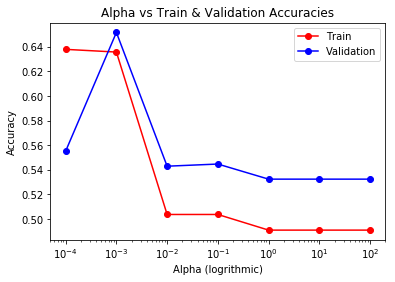

In [53]:
alph = 0.0001 # Use to increment by alpha
i = 0 # Increment through matrix
ava = np.zeros(shape=(7,3)) # Array to store alpha values and test & train accuracies

# Populate 3d matrix with alpha, train accuracies, and test accuracies
while alph <= 100 :
    print("--alpha = %s--" % alph)
    log_reg = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, alpha = alph)
    log_reg.fit(X_train, Y_train)

    train_accuracy = accuracy_score(Y_train, log_reg.predict(X_train))
    validation_accuracy = accuracy_score(Y_validation, log_reg.predict(X_validation))

    ava[i] = [alph, train_accuracy,validation_accuracy]
    
    print("Training accuracy: %0.6f" % train_accuracy)
    print("Validation accuracy: %0.6f" % validation_accuracy)
    
    alph *= 10
    i += 1

#Plot of Alpha vs. Test / Train Accuracies
mpl.plot(ava[:,0],ava[:,1],'r-o',label='Train')
mpl.plot(ava[:,0],ava[:,2],'b-o',label='Validation')
mpl.xscale('log')
mpl.xlabel('Alpha (logrithmic)')
mpl.ylabel('Accuracy')
mpl.legend(loc='upper right')
mpl.title('Alpha vs Train & Validation Accuracies')

mpl.savefig('logreg_plot.png')

mpl.show()
print("\n")

#### Non-Linear Classification - RBF

	C = 0.0001
		Training accuracy: 0.493211
		Validation accuracy: 0.455342
	C = 0.001
		Training accuracy: 0.493211
		Validation accuracy: 0.455342
	C = 0.01
		Training accuracy: 0.493211
		Validation accuracy: 0.455342
	C = 0.1
		Training accuracy: 0.547963
		Validation accuracy: 0.527145
	C = 1.0
		Training accuracy: 0.637757
		Validation accuracy: 0.646235
	C = 10.0
		Training accuracy: 0.644766
		Validation accuracy: 0.635727
	C = 100.0
		Training accuracy: 0.653526
		Validation accuracy: 0.658494
	C = 1000.0
		Training accuracy: 0.664915
		Validation accuracy: 0.632224


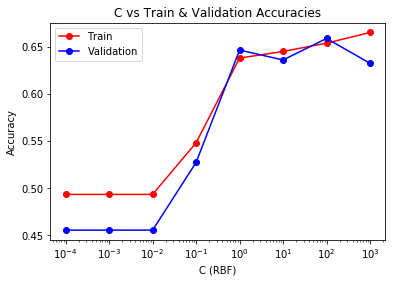

In [69]:
# Use RBF as classifier
accArray = np.zeros((8,3))

c = 0.0001
i = 0
while c <= 1000 :
    
    rbf = SVC(kernel='rbf', C=c, random_state=123)
    rbf.fit(X_train, Y_train)

    accArray[i][0] = c # C-Value
    accArray[i][1] = accuracy_score(Y_train, rbf.predict(X_train)) # Train Accuracy
    accArray[i][2] = accuracy_score(Y_validation, rbf.predict(X_validation)) # Test Accuracy
    
    print("\tC =", accArray[i][0])
    print("\t\tTraining accuracy: %0.6f" % accArray[i][1])
    print("\t\tValidation accuracy: %0.6f" % accArray[i][2])
    c *= 10
    i += 1

mpl.plot(accArray[:,0],accArray[:,1],'r-o',label='Train')
mpl.plot(accArray[:,0],accArray[:,2],'b-o',label='Validation')
mpl.xscale('log')
mpl.xlabel('C (RBF)')
mpl.ylabel('Accuracy')
mpl.legend(loc='upper left')
mpl.title('C vs Train & Validation Accuracies')

mpl.savefig('rbf_plot.png')

mpl.show()
print("\n")

#### Generative Classifier - Naive Bayes

In [61]:
# Use Naive Bayes to predict fighter
gauss = GaussianNB()
gauss.fit(X_train, Y_train)
print("Gaussian Naive Bayes Training Accuracy Score: %0.6f" % accuracy_score(Y_train, gauss.predict(X_train)))
print("Gaussian Naive Bayes Validation Accuracy Score: %0.6f" % accuracy_score(Y_validation, gauss.predict(X_validation)))

Gaussian Naive Bayes Training Accuracy Score: 0.605782
Gaussian Naive Bayes Validation Accuracy Score: 0.465849


### Tuning Parameters

	gamma = 0.1
		Training accuracy: 0.659220
		Validation accuracy: 0.640981
	gamma = 0.010000000000000002
		Training accuracy: 0.643452
		Validation accuracy: 0.619965
	gamma = 0.0010000000000000002
		Training accuracy: 0.640823
		Validation accuracy: 0.646235
	gamma = 0.00010000000000000003
		Training accuracy: 0.599212
		Validation accuracy: 0.576182
	gamma = 1.0000000000000004e-05
		Training accuracy: 0.493211
		Validation accuracy: 0.455342


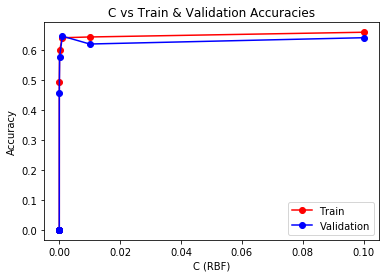

In [68]:
# Test difference gammas for accuracy
accArray = np.zeros((10,3))

g = 0.1
i = 0
while g >= 0.00001 :
    
    rbf = SVC(kernel='rbf', C=100, random_state=123, gamma=g)
    rbf.fit(X_train, Y_train)

    accArray[i][0] = g # C-Value
    accArray[i][1] = accuracy_score(Y_train, rbf.predict(X_train)) # Train Accuracy
    accArray[i][2] = accuracy_score(Y_validation, rbf.predict(X_validation)) # Test Accuracy
    
    print("\tgamma =", accArray[i][0])
    print("\t\tTraining accuracy: %0.6f" % accArray[i][1])
    print("\t\tValidation accuracy: %0.6f" % accArray[i][2])
    g *= 0.1
    i += 1

mpl.plot(accArray[:,0],accArray[:,1],'r-o',label='Train')
mpl.plot(accArray[:,0],accArray[:,2],'b-o',label='Validation')
# mpl.xscale('log')
mpl.xlabel('C (RBF)')
mpl.ylabel('Accuracy')
mpl.legend(loc='lower right')
mpl.title('C vs Train & Validation Accuracies')

mpl.savefig('rbf_plot_gamma.png')

mpl.show()
print("\n")

In [65]:
rbf = SVC(kernel='rbf', C=1000, random_state=123)
rbf.fit(X_train, Y_train)

print("Training accuracy: %0.6f" % accuracy_score(Y_train, rbf.predict(X_train)))
print("Validation accuracy: %0.6f" % accuracy_score(Y_validation, rbf.predict(X_validation)))

Training accuracy: 0.664915
Validation accuracy: 0.632224


## Final Prediction

In [66]:
# Transform the test data
X_test = min_max_scalar.fit_transform(X_test)

print("Test accuracy: %0.6f" % accuracy_score(Y_test, rbf.predict(X_test)))

Test accuracy: 0.581232


### Error Analysis

In [67]:
# Confucion matrix
confMatrix = confusion_matrix(Y_test, rbf.predict(X_test))

print("__Confusion Matrix__")
print(confMatrix)

__Confusion Matrix__
[[235   0 126]
 [ 12   0   4]
 [157   0 180]]
